## EDA

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

In [3]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df.shape

(2111, 17)

In [5]:
df.dtypes

Gender                             object
Age                                 int64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [6]:
df.nunique()

Gender                               2
Age                                 40
Height                              51
Weight                            1335
family_history_with_overweight       2
FAVC                                 2
FCVC                               180
NCP                                256
CAEC                                 4
SMOKE                                2
CH2O                               201
SCC                                  2
FAF                                257
TUE                                813
CALC                                 4
MTRANS                               5
NObeyesdad                           7
dtype: int64

In [7]:
df['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

In [8]:
df['NObeyesdad'].value_counts(normalize=True)

NObeyesdad
Obesity_Type_I         0.166272
Obesity_Type_III       0.153482
Obesity_Type_II        0.140692
Overweight_Level_I     0.137376
Overweight_Level_II    0.137376
Normal_Weight          0.135955
Insufficient_Weight    0.128849
Name: proportion, dtype: float64

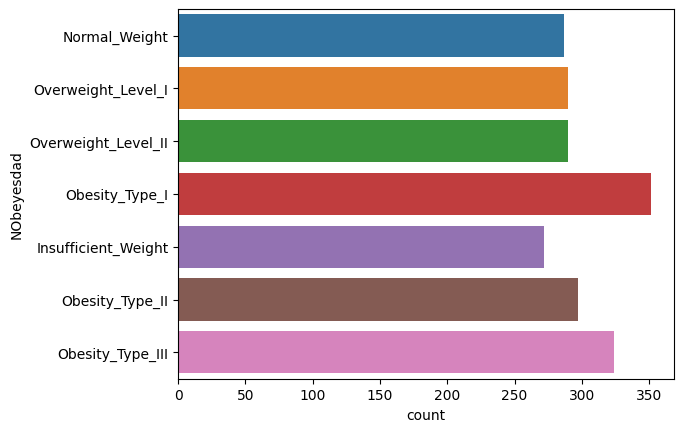

In [9]:
sns.countplot(y =df['NObeyesdad'])
plt.show()

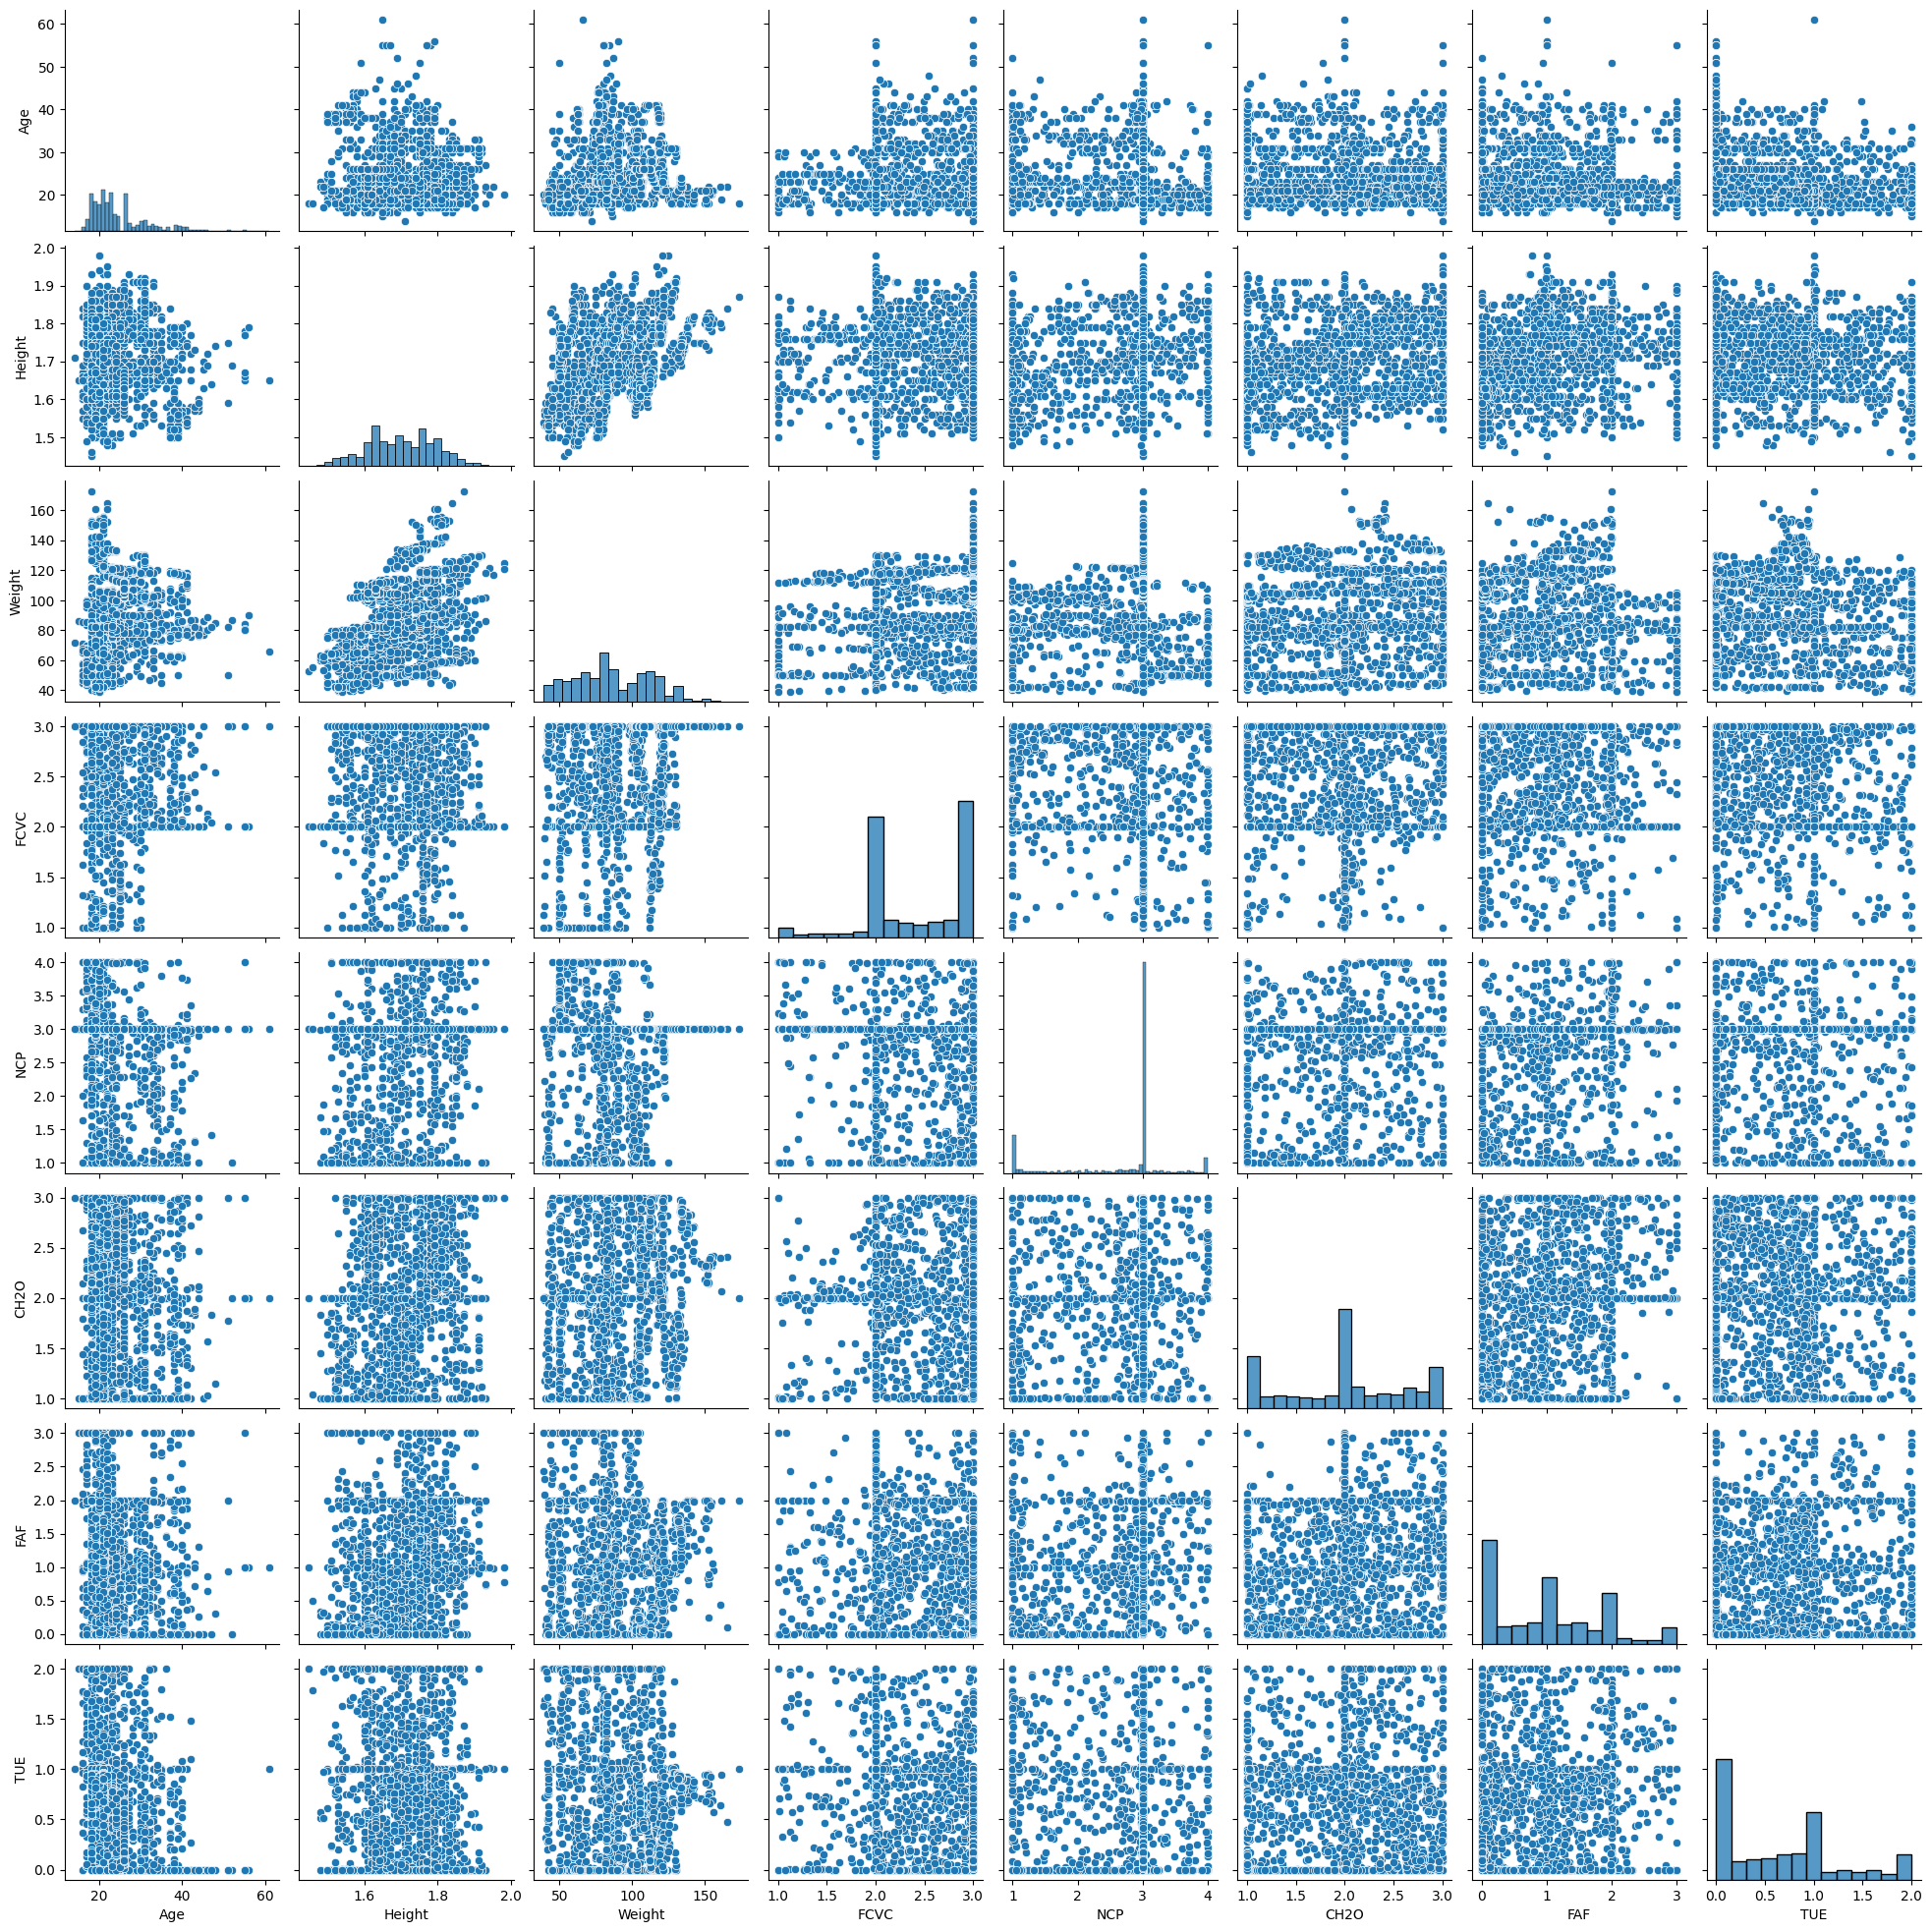

In [13]:
sns.pairplot(df)

### preprocessing

In [14]:
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [15]:
df.duplicated().sum()

24

In [16]:
df.drop_duplicates(inplace = True)

In [17]:
def most_redundant_value(df):
    redundant_info = {}

    for col in df.columns:
        most_frequent_value = df[col].mode().iloc[0]  # Get the most common value
        count = df[col].value_counts().iloc[0]        # Get the count of that value

        redundant_info[col] = {
            'most_redundant_value': most_frequent_value,
            'repeated_times': count
        }
    redundant_df =pd.DataFrame(redundant_info).transpose()

    redundant_df['red_percentage'] = redundant_df['repeated_times'] /df.shape[0]
    redunduant_features = []
    for row in redundant_df.itertuples():
        if row.red_percentage >= 0.8:
            redunduant_features.append(row.Index)
        
    df.drop(redunduant_features, axis=1, inplace=True)

    
    return df
df =most_redundant_value(df)

### encoding and feature scaling

In [18]:
####  remove outlires
def remove_outliers(df):
    numeric_columns = df.select_dtypes(include=['number']).columns
    outliers_removed = {}
    
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
        
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
        
        if outliers > 0:
            outliers_removed[column] = outliers
            
    return df, outliers_removed

In [19]:
df , outliers = remove_outliers(df)


In [20]:
outliers

{'Age': 160, 'Weight': 1, 'NCP': 578}

In [21]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols].nunique()

Gender        2
CALC          4
MTRANS        5
NObeyesdad    7
dtype: int64

In [22]:
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

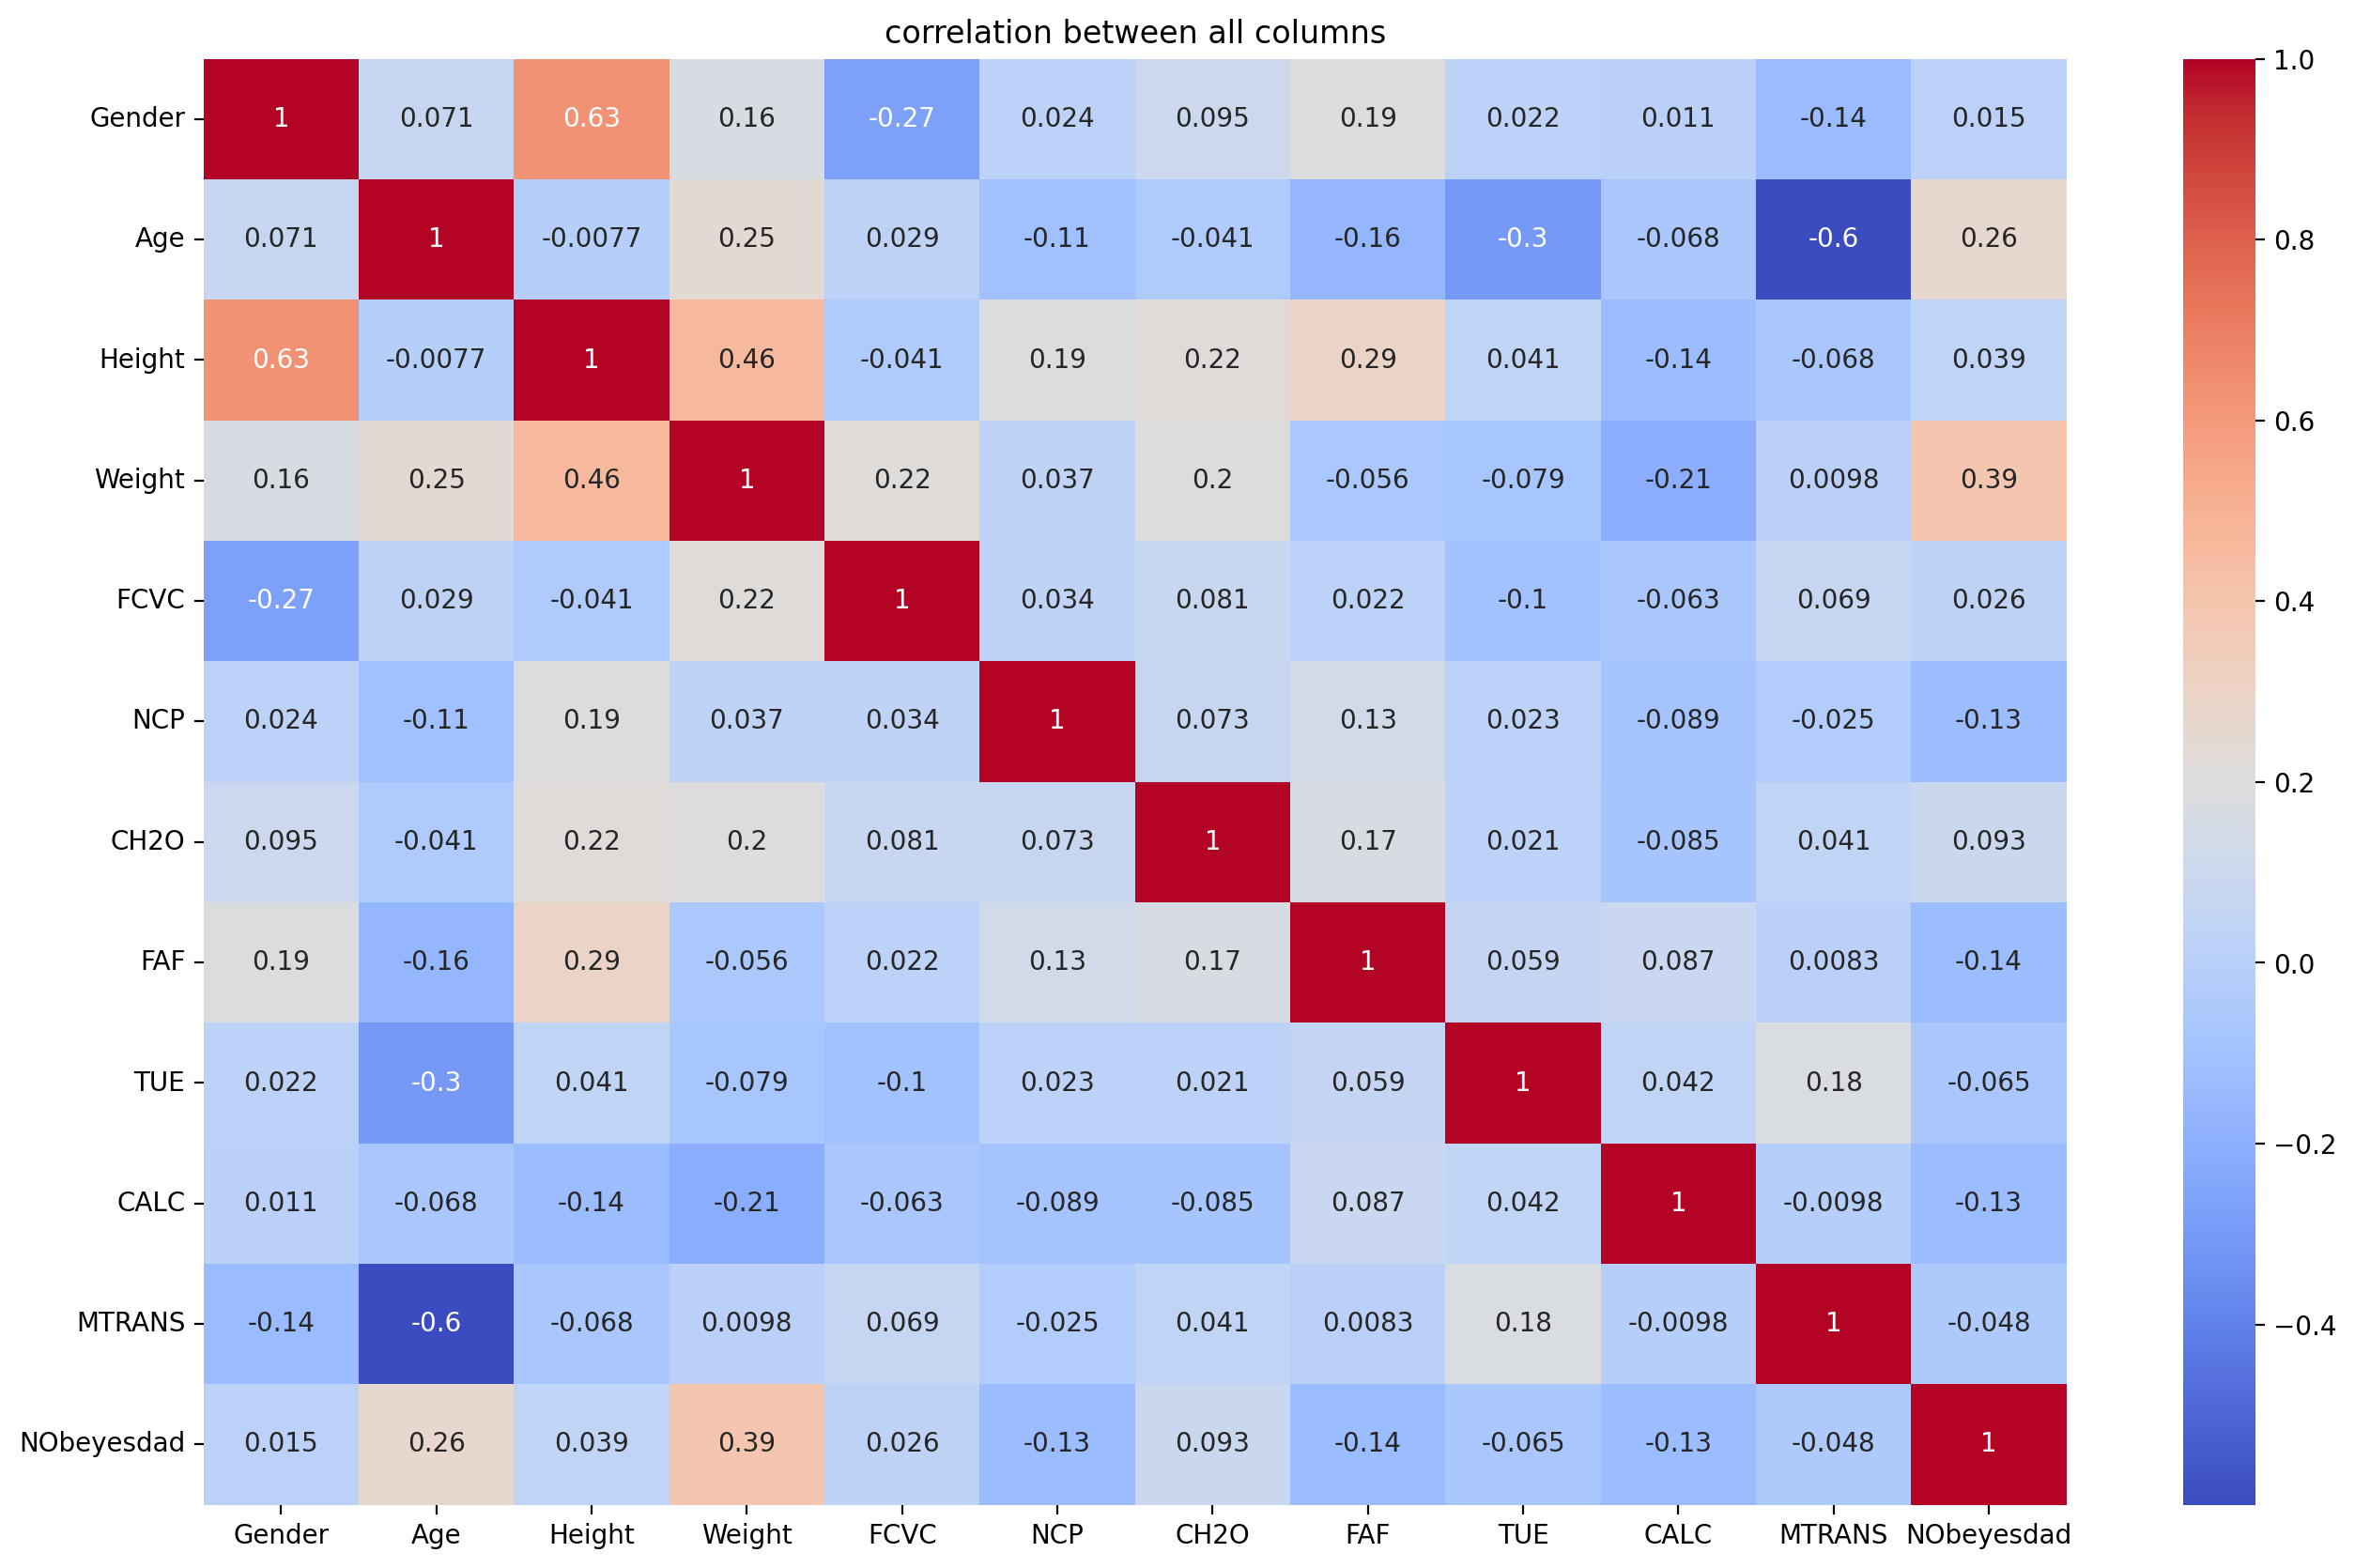

In [23]:


plt.figure(figsize=(16, 10),dpi=200)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('correlation between all columns')
plt.show()

In [24]:
x = df.iloc[: , :-1]
y = df.iloc[: , -1]

In [25]:
scaler = MinMaxScaler()
columns_x= df.columns


x_scaled_np = scaler.fit_transform(df)

x = pd.DataFrame(x_scaled_np , columns=columns_x)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [27]:
x_train.shape

(1878, 12)

In [28]:
x

,Gender,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0.0,0.333333,0.320755,0.189340,0.5,0.625,0.500,0.000000,0.5000,1.000000,0.75,0.166667
1,0.0,0.333333,0.132075,0.128751,1.0,0.625,1.000,1.000000,0.0000,0.666667,0.75,0.166667
2,1.0,0.428571,0.660377,0.287797,0.5,0.625,0.500,0.666667,0.5000,0.333333,0.75,0.166667
3,1.0,0.619048,0.660377,0.363533,1.0,0.625,0.500,0.666667,0.0000,0.333333,1.00,0.833333
4,1.0,0.380952,0.622642,0.384739,0.5,0.000,0.500,0.000000,0.0000,0.666667,0.75,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2082,0.0,0.333333,0.490566,0.699877,1.0,0.625,0.365,0.560000,0.4530,0.666667,0.75,0.666667
2083,0.0,0.380952,0.566038,0.717523,1.0,0.625,0.505,0.446667,0.2995,0.666667,0.75,0.666667
2084,0.0,0.428571,0.566038,0.717145,1.0,0.625,0.525,0.470000,0.3230,0.666667,0.75,0.666667
2085,0.0,0.476190,0.547170,0.714570,1.0,0.625,0.925,0.380000,0.2930,0.666667,0.75,0.666667


### training and evaluating

In [29]:
model = LogisticRegression(random_state= 11)

In [30]:
model.fit(x_train , y_train)

LogisticRegression(random_state=11)

In [31]:
model.score(x_test , y_test)

0.9330143540669856

In [32]:
y_pred = model.predict(x_test)

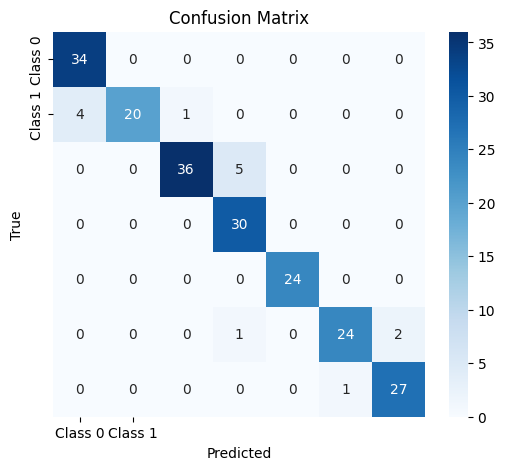

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [34]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9330
Precision: 0.9392
Recall: 0.9330
F1-Score: 0.9325
